In [22]:
from matplotlib import pyplot as plt

# Defining the ALP spectrum

In [367]:
import numpy as np
import astropy.units as astropy_units
from astromodels.functions.function import (
    Function1D,
    FunctionMeta,
)

class ALPProductionSpectrum(Function1D, metaclass=FunctionMeta):
    r"""
    description :
        ALP production spectrum following Equation 2 from Xiao et al. 2021.
        Includes Bremsstrahlung, Compton, and Primakoff processes.
        Returns dNa/dE in units of keV^-1 s^-1
        
    latex : $ \frac{dN_a}{dE} = \frac{10^{42}}{\rm keV\,s} [C^B g_{13}^2 (\frac{E}{E_0^B})^{\beta^B} e^{-(\beta^B+1)E/E_0^B} + C^C g_{13}^2 (\frac{E}{E_0^C})^{\beta^C} e^{-(\beta^C+1)E/E_0^C} + C^P g_{11}^2 (\frac{E}{E_0^P})^{\beta^P} e^{-(\beta^P+1)E/E_0^P}] $
    
    parameters :
        g_agamma :
            desc : ALP-photon coupling (10^-11 GeV^-1)
            initial value : 1.0
            min : 0
            max : 100
            fix : False
            
        g_ae :
            desc : ALP-electron coupling (10^-13)
            initial value : 1.0
            min : 0
            max : 100
            fix : False
            
        C_B :
            desc : Bremsstrahlung normalization
            initial value : 1.0
            min : 0
            max : 100
            fix : True
            
        E0_B :
            desc : Bremsstrahlung average energy (keV)
            initial value : 100.0
            min : 1
            max : 1000
            fix : True
            
        beta_B :
            desc : Bremsstrahlung spectral index
            initial value : 1.0
            min : 0
            max : 10
            fix : True
            
        C_C :
            desc : Compton normalization
            initial value : 150
            min : 0
            max : 1000
            fix : True
            
        E0_C :
            desc : Compton average energy (keV)
            initial value : 250.0
            min : 1
            max : 1000
            fix : True
            
        beta_C :
            desc : Compton spectral index
            initial value : 3.0
            min : 0
            max : 10
            fix : True
            
        C_P :
            desc : Primakoff normalization
            initial value : 13.0
            min : 0
            max : 100
            fix : True
            
        E0_P :
            desc : Primakoff average energy (keV)
            initial value : 200.0
            min : 1
            max : 1000
            fix : True
            
        beta_P :
            desc : Primakoff spectral index
            initial value : 2.0
            min : 0
            max : 10
            fix : True
            
        BT :
            desc : Transverse magnetic field (μG)
            initial value : 1.4
            min : 0.1
            max : 10
            fix : True
            
        distance :
            desc : Distance (pc)
            initial value : 200.0
            min : 1
            max : 1000
            fix : True
            
        ne :
            desc : Electron density (cm^-3)
            initial value : 0.013
            min : 0.001
            max : 1.0
            fix : True

        ma :
            desc : ALP mass (10^-11 eV)
            initial value : 1.0
            min : 0
            max : 100
            fix : True
    """
    
    def _set_units(self, x_unit, y_unit):
        """Set units for all parameters"""
        self.g_agamma.unit = 1/astropy_units.GeV
        self.g_ae.unit = astropy_units.dimensionless_unscaled
        self.E0_B.unit = astropy_units.keV
        self.E0_C.unit = astropy_units.keV
        self.E0_P.unit = astropy_units.keV
        self.ma.unit = astropy_units.eV
        self.BT.unit = astropy_units.microGauss
        self.distance.unit = astropy_units.pc
        self.ne.unit = astropy_units.dimensionless_unscaled
        
        # Set units for spectral parameters
        for prefix in ['B', 'C', 'P']:
            getattr(self, f'C_{prefix}').unit = astropy_units.dimensionless_unscaled
            getattr(self, f'E0_{prefix}').unit = astropy_units.keV
            getattr(self, f'beta_{prefix}').unit = astropy_units.dimensionless_unscaled
    
    def get_bremsstrahlung(self, E, g_ae=None, C_B=None, E0_B=None, beta_B=None):
        """
        Calculate Bremsstrahlung component.
        Uses stored values unless overridden by provided parameters.
        Also updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_ae is not None: self.g_ae.value = g_ae
        if C_B is not None: self.C_B.value = C_B
        if E0_B is not None: self.E0_B.value = E0_B
        if beta_B is not None: self.beta_B.value = beta_B
        
        rate = 1e42 * self.C_B.value * self.g_ae.value**2 * \
               (E/self.E0_B.value)**self.beta_B.value * \
               np.exp(-(self.beta_B.value + 1)*E/self.E0_B.value)

        return rate * astropy_units.keV**-1 * astropy_units.s**-1
    
    def get_compton(self, E, g_ae=None, C_C=None, E0_C=None, beta_C=None):
        """
        Calculate Compton component.
        Uses stored values unless overridden by provided parameters.
        Also updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_ae is not None: self.g_ae.value = g_ae
        if C_C is not None: self.C_C.value = C_C
        if E0_C is not None: self.E0_C.value = E0_C
        if beta_C is not None: self.beta_C.value = beta_C
        
        rate = 1e42 * self.C_C.value * self.g_ae.value**2 * \
               (E/self.E0_C.value)**self.beta_C.value * \
               np.exp(-(self.beta_C.value + 1)*E/self.E0_C.value)
        return rate * astropy_units.keV**-1 * astropy_units.s**-1
    
    def get_primakoff(self, E, g_agamma=None, C_P=None, E0_P=None, beta_P=None):
        """
        Calculate Primakoff component.
        Uses stored values unless overridden by provided parameters.
        Also updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if C_P is not None: self.C_P.value = C_P
        if E0_P is not None: self.E0_P.value = E0_P
        if beta_P is not None: self.beta_P.value = beta_P
        
        rate = 1e42 * self.C_P.value * self.g_agamma.value**2 * \
               (E/self.E0_P.value)**self.beta_P.value * \
               np.exp(-(self.beta_P.value + 1)*E/self.E0_P.value)
        return rate * astropy_units.keV**-1 * astropy_units.s**-1
        
   
    def get_total(self, E, g_agamma=None, g_ae=None,
                  C_B=None, E0_B=None, beta_B=None,
                  C_C=None, E0_C=None, beta_C=None,
                  C_P=None, E0_P=None, beta_P=None):
        """
        Calculate total ALP production rate.
        Uses stored values unless overridden by provided parameters.
        Updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        
        if C_B is not None: self.C_B.value = C_B
        if E0_B is not None: self.E0_B.value = E0_B
        if beta_B is not None: self.beta_B.value = beta_B
        
        if C_C is not None: self.C_C.value = C_C
        if E0_C is not None: self.E0_C.value = E0_C
        if beta_C is not None: self.beta_C.value = beta_C
        
        if C_P is not None: self.C_P.value = C_P
        if E0_P is not None: self.E0_P.value = E0_P
        if beta_P is not None: self.beta_P.value = beta_P
        
        return (self.get_bremsstrahlung(E) + 
            self.get_compton(E) + 
            self.get_primakoff(E))

    def get_bremsstrahlung_flux(self, x, g_agamma=None, g_ae=None, 
                           C_B=None, E0_B=None, beta_B=None,
                           BT=None, distance=None, ne=None, ma=None):
        """Calculate photon flux from Bremsstrahlung process only"""
        # Update stored values if new ones provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        if C_B is not None: self.C_B.value = C_B
        if E0_B is not None: self.E0_B.value = E0_B
        if beta_B is not None: self.beta_B.value = beta_B
        if ma is not None: self.ma.value = ma
        if BT is not None: self.BT.value = BT
        if distance is not None: self.distance.value = distance
        if ne is not None: self.ne.value = ne
    
        # Get Bremsstrahlung ALP production
        dNa_dE = self.get_bremsstrahlung(x)
        
        # Calculate q parameter
        qd = (77 * (self.ma.value * 1e-1)**2 - 0.14 * (self.ne.value/0.013)) * \
            (self.distance.value/197) * (1/x)
        
        # Calculate conversion probability
        Pa = 8.7e-6 * self.g_agamma.value**2 * (self.BT.value/1.0)**2 * \
             (self.distance.value/197)**2 * np.sin(qd)**2 / qd**2
        
        # Convert distance to cm for flux calculation
        distance_cm = (self.distance.value * astropy_units.pc).to(astropy_units.cm)
        
        # Calculate flux with proper units throughout
        flux = dNa_dE * Pa / (4 * np.pi * distance_cm**2)
        
        return flux
    
    def get_compton_flux(self, x, g_agamma=None, g_ae=None,
                        C_C=None, E0_C=None, beta_C=None,
                        BT=None, distance=None, ne=None, ma=None):
        """Calculate photon flux from Compton process only"""
        # Update stored values if new ones provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        if C_C is not None: self.C_C.value = C_C
        if E0_C is not None: self.E0_C.value = E0_C
        if beta_C is not None: self.beta_C.value = beta_C
        if ma is not None: self.ma.value = ma
        if BT is not None: self.BT.value = BT
        if distance is not None: self.distance.value = distance
        if ne is not None: self.ne.value = ne
    
        # Get Compton ALP production
        dNa_dE = self.get_compton(x)
        
        # Calculate q parameter
        qd = (77 * (self.ma.value * 1e-1)**2 - 0.14 * (self.ne.value/0.013)) * \
            (self.distance.value/197) * (1/x)
        
        # Calculate conversion probability
        Pa = 8.7e-6 * self.g_agamma.value**2 * (self.BT.value/1.0)**2 * \
             (self.distance.value/197)**2 * np.sin(qd)**2 / qd**2
        
        # Convert distance to cm for flux calculation
        distance_cm = (self.distance.value * astropy_units.pc).to(astropy_units.cm)
        
        # Calculate flux with proper units throughout
        flux = dNa_dE * Pa / (4 * np.pi * distance_cm**2)
        
        return flux

    def get_primakoff_flux(self, x, g_agamma=None, g_ae=None,
                          C_P=None, E0_P=None, beta_P=None,
                          BT=None, distance=None, ne=None, ma=None):
        """Calculate photon flux from Primakoff process only"""
        # Update stored values if new ones provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        if C_P is not None: self.C_P.value = C_P
        if E0_P is not None: self.E0_P.value = E0_P
        if beta_P is not None: self.beta_P.value = beta_P
        if ma is not None: self.ma.value = ma
        if BT is not None: self.BT.value = BT
        if distance is not None: self.distance.value = distance
        if ne is not None: self.ne.value = ne
    
        # Get Primakoff ALP production
        dNa_dE = self.get_primakoff(x)
        
        # Calculate q parameter
        qd = (77 * (self.ma.value * 1e-1)**2 - 0.14 * (self.ne.value/0.013)) * \
            (self.distance.value/197) * (1/x)
        
        # Calculate conversion probability
        Pa = 8.7e-6 * self.g_agamma.value**2 * (self.BT.value/1.0)**2 * \
             (self.distance.value/197)**2 * np.sin(qd)**2 / qd**2
        
         # Convert distance to cm for flux calculation
        distance_cm = (self.distance.value * astropy_units.pc).to(astropy_units.cm)
        
        # Calculate flux with proper units throughout
        flux = dNa_dE * Pa / (4 * np.pi * distance_cm**2)
        
        return flux
    
    def evaluate(self, x, g_agamma=None, g_ae=None, 
                C_B=None, E0_B=None, beta_B=None,
                C_C=None, E0_C=None, beta_C=None,
                C_P=None, E0_P=None, beta_P=None,
                BT=None, distance=None, ne=None, ma=None):
        """
        Calculate differential photon flux.
        Uses stored values unless overridden by provided parameters.
        Updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        
        if C_B is not None: self.C_B.value = C_B
        if E0_B is not None: self.E0_B.value = E0_B
        if beta_B is not None: self.beta_B.value = beta_B
        
        if C_C is not None: self.C_C.value = C_C
        if E0_C is not None: self.E0_C.value = E0_C
        if beta_C is not None: self.beta_C.value = beta_C
        
        if C_P is not None: self.C_P.value = C_P
        if E0_P is not None: self.E0_P.value = E0_P
        if beta_P is not None: self.beta_P.value = beta_P
        
        if ma is not None: self.ma.value = ma
        if BT is not None: self.BT.value = BT
        if distance is not None: self.distance.value = distance
        if ne is not None: self.ne.value = ne
        
        # Calculate total rate with updated stored values
        dNa_dE = self.get_total(x)
        
        # Calculate q parameter
        qd = (77 * (self.ma.value * 1e-1)**2 - 0.14 * (self.ne.value/0.013)) * \
            (self.distance.value/197) * (1/x)
        
        # Calculate conversion probability
        Pa = 8.7e-6 * self.g_agamma.value**2 * (self.BT.value/1.0)**2 * \
             (self.distance.value/197)**2 * np.sin(qd)**2 / qd**2
        
        # Convert distance to cm for flux calculation
        distance_cm = (self.distance.value * astropy_units.pc).to(astropy_units.cm)
        
        # Calculate flux with proper units throughout
        flux = dNa_dE * Pa / (4 * np.pi * distance_cm**2)
        
        return flux

In [368]:
model = ALPProductionSpectrum()

In [369]:
E = np.logspace(0,3,1000)

In [370]:
g_ae = 1.0
g_agamma = 1.0

# parameters for t_cc = 480yr

In [371]:
C_P = 13.0
E0_P = 180
beta_P = 2.0

In [372]:
C_B = 0.789
E0_B = 134.54
beta_B = 1.02

In [373]:
C_C = 153.2
E0_C = 279.9
beta_C = 3.15

In [374]:
# Get just Bremsstrahlung
brem = model.get_bremsstrahlung(E, g_ae, C_B, E0_B, beta_B)

# Get just Compton
compton = model.get_compton(E, g_ae, C_C, E0_C, beta_C)

# Get just Primakoff
primakoff = model.get_primakoff(E, g_agamma, C_P, E0_P, beta_P)

In [375]:
brem

<Quantity [5.23754782e+39, 5.27406916e+39, 5.31084132e+39, 5.34786598e+39,
           5.38514481e+39, 5.42267950e+39, 5.46047175e+39, 5.49852327e+39,
           5.53683578e+39, 5.57541102e+39, 5.61425072e+39, 5.65335664e+39,
           5.69273054e+39, 5.73237420e+39, 5.77228939e+39, 5.81247793e+39,
           5.85294161e+39, 5.89368225e+39, 5.93470169e+39, 5.97600176e+39,
           6.01758431e+39, 6.05945121e+39, 6.10160433e+39, 6.14404556e+39,
           6.18677679e+39, 6.22979993e+39, 6.27311690e+39, 6.31672964e+39,
           6.36064009e+39, 6.40485019e+39, 6.44936193e+39, 6.49417727e+39,
           6.53929820e+39, 6.58472674e+39, 6.63046489e+39, 6.67651467e+39,
           6.72287813e+39, 6.76955732e+39, 6.81655430e+39, 6.86387114e+39,
           6.91150993e+39, 6.95947278e+39, 7.00776178e+39, 7.05637907e+39,
           7.10532678e+39, 7.15460706e+39, 7.20422208e+39, 7.25417400e+39,
           7.30446502e+39, 7.35509733e+39, 7.40607315e+39, 7.45739470e+39,
           7.50906422e+39

(0.01, 10)

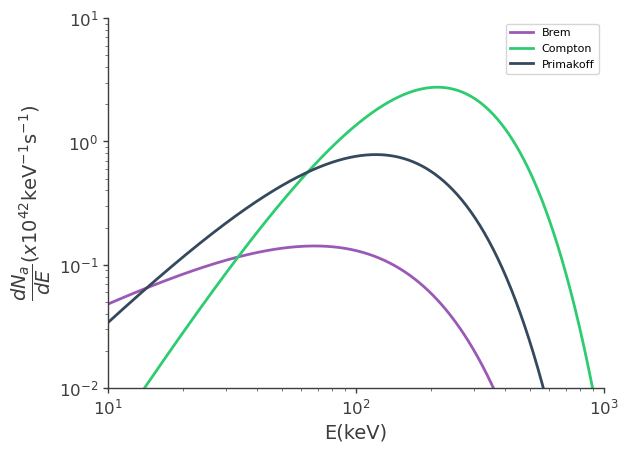

In [376]:
plt.plot(E, brem/1e42, label='Brem')
plt.plot(E, compton/1e42, label='Compton')
plt.plot(E, primakoff/1e42, label='Primakoff')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E(keV)')
plt.ylabel('$\dfrac{dN_a}{dE}(x10^{42} \mathrm{keV^{-1}s^{-1}})$')
plt.legend()
plt.xlim(10,1000)
plt.ylim(1e-2,10)

In [377]:
total = model.get_total(E)

(0.01, 10)

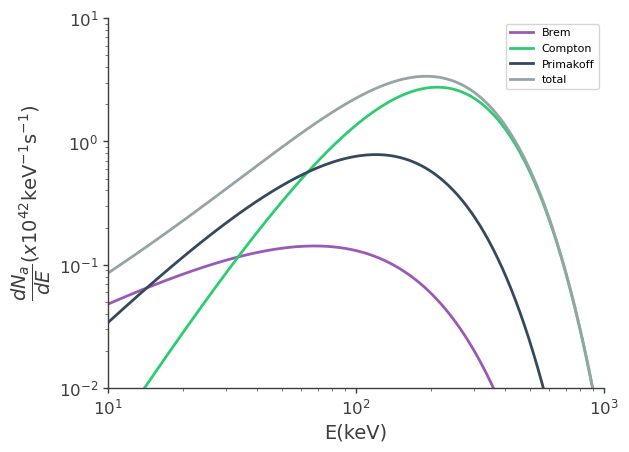

In [378]:
plt.plot(E, brem/1e42, label='Brem')
plt.plot(E, compton/1e42, label='Compton')
plt.plot(E, primakoff/1e42, label='Primakoff')
plt.plot(E, total/1e42, label='total')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E(keV)')
plt.ylabel('$\dfrac{dN_a}{dE}(x10^{42} \mathrm{keV^{-1}s^{-1}})$')
plt.legend()
plt.xlim(10,1000)
plt.ylim(1e-2,10)

In [379]:
total_alt = model.get_total(E,g_agamma=g_agamma, g_ae=g_ae, C_B=C_B, C_C=C_C, C_P=C_P, E0_B=E0_B,E0_C=E0_C,E0_P=E0_P, beta_B=beta_B,beta_C=beta_C,beta_P=beta_P)

(0.01, 10)

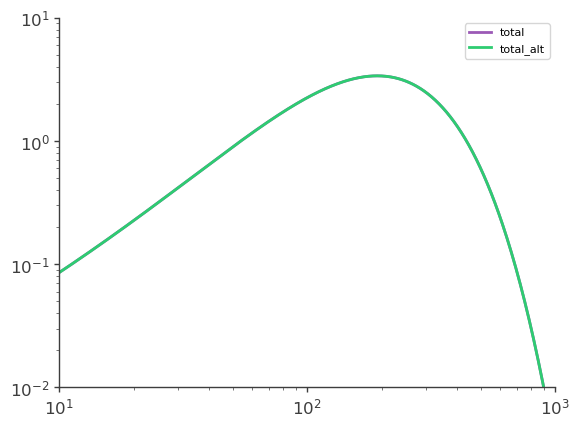

In [380]:
# plt.plot(E, brem/1e42, label='Brem')
# plt.plot(E, compton/1e42, label='Compton')
# plt.plot(E, primakoff/1e42, label='Primakoff')
plt.plot(E, total/1e42, label='total')
plt.plot(E, total_alt/1e42, label='total_alt')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(10,1000)
plt.ylim(1e-2,10)

In [381]:
brem_flux = model.get_bremsstrahlung_flux(E,g_agamma=1.5)

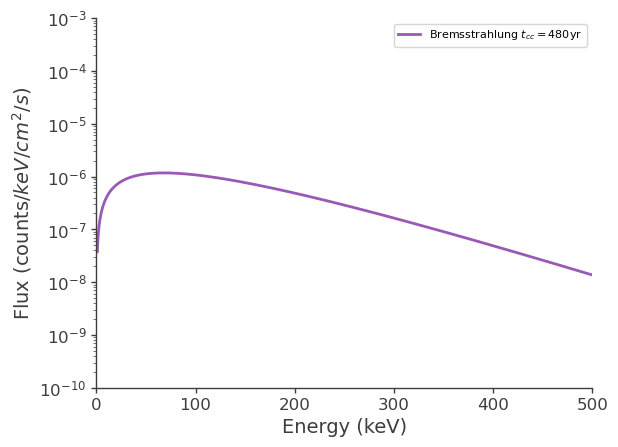

In [382]:
plt.plot(E,brem_flux,label='Bremsstrahlung $t_{cc} = 480 \mathrm{yr}$')
# plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-10,1e-3)
plt.xlim(0,500)
plt.xlabel('Energy (keV)')
plt.ylabel('Flux $(\mathrm{counts} / keV / cm^2 / s)$')
plt.legend()

In [383]:
comp_flux = model.get_compton_flux(E,g_agamma=1.5)

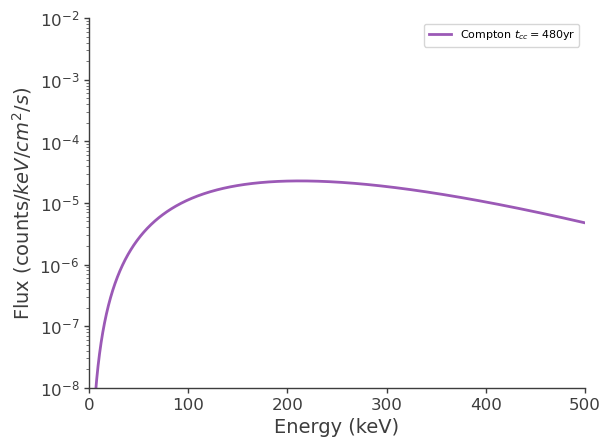

In [384]:
plt.plot(E,comp_flux, label='Compton $t_{cc} = 480 \mathrm{yr}$')
# plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8,1e-2)
plt.xlim(0,500)
plt.xlabel('Energy (keV)')
plt.ylabel('Flux $(\mathrm{counts} / keV / cm^2 / s)$')
plt.legend()

# parameters from table 1. Xiao et. al 2022

In [385]:
t_cc = np.array([155000, 23000, 13000, 10000, 6900, 3700, 730, 480, 110, 34, 7.2, 3.6])
C_P = np.array([1.36, 4.0, 5.2, 5.7, 6.5, 7.9, 12, 13, 16, 21, 28, 26])
E0_P = np.array([50, 80, 99, 110, 120, 130, 170, 180, 210, 240, 280, 320])
beta_P = np.array([1.95] + [2.0] * 10 + [1.8])
C_B = np.array([1.3e-3, 2.3e-2, 6.4e-2, 8.9e-2, 0.136, 0.249, 0.827, 0.789, 1.79, 2.82, 3.77, 3.86])
E0_B = np.array([35.26, 56.57, 70.77, 76.65, 85.15, 97.44, 129.17, 134.54, 151.46, 181.74, 207.84, 224.45])
beta_B = np.array([1.16, 1.16, 1.09, 1.08, 1.06, 1.04, 1.02, 1.02, 1.02, 1.00, 0.99, 0.98])
C_C = np.array([1.39, 8.55, 17.39, 22.49, 31.81, 50.62, 138.6, 153.2, 252.7, 447.5, 729.2, 856.4])
E0_C = np.array([77.86, 125.8, 156.9, 169.2, 186.4, 210.4, 269.1, 279.9, 316.8, 363.3, 415.7, 481.2])
beta_C = np.array([3.15, 3.12, 3.09, 3.09, 3.09, 3.11, 3.17, 3.15, 3.17, 3.22, 3.23, 3.11])

In [386]:
line_styles = ['--'] * 4 + ['-'] * 4 + ['-.'] * 4 

# calculating Bremsstrahlung flux for all t_cc. same as Fig. 2(a) Xiao et. al. 2022

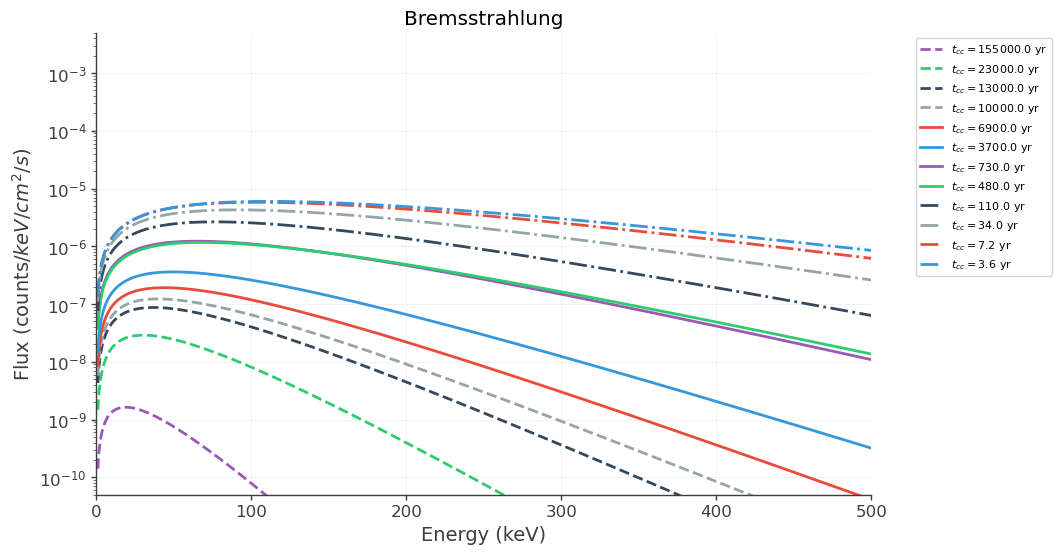

In [387]:
plt.figure(figsize=(10, 6))  # Create a larger figure

for i in range(12):
    plt.plot(E, model.get_bremsstrahlung_flux(E, 
                                             g_agamma=1.5, 
                                             C_B=C_B[i], 
                                             E0_B=E0_B[i], 
                                             beta_B=beta_B[i]), 
             linestyle = line_styles[i],
             label=f'$t_{{cc}} = {t_cc[i]}$ yr')

plt.xlabel('Energy (keV)')
plt.ylabel('Flux $(\mathrm{counts} / keV / cm^2 / s)$')
plt.title('Bremsstrahlung')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')
plt.xlim(0,500)
plt.ylim(5e-11,5e-3)
plt.show()

# calculating Compton flux for all t_cc. same as Fig. 2(b) Xiao et. al. 2022

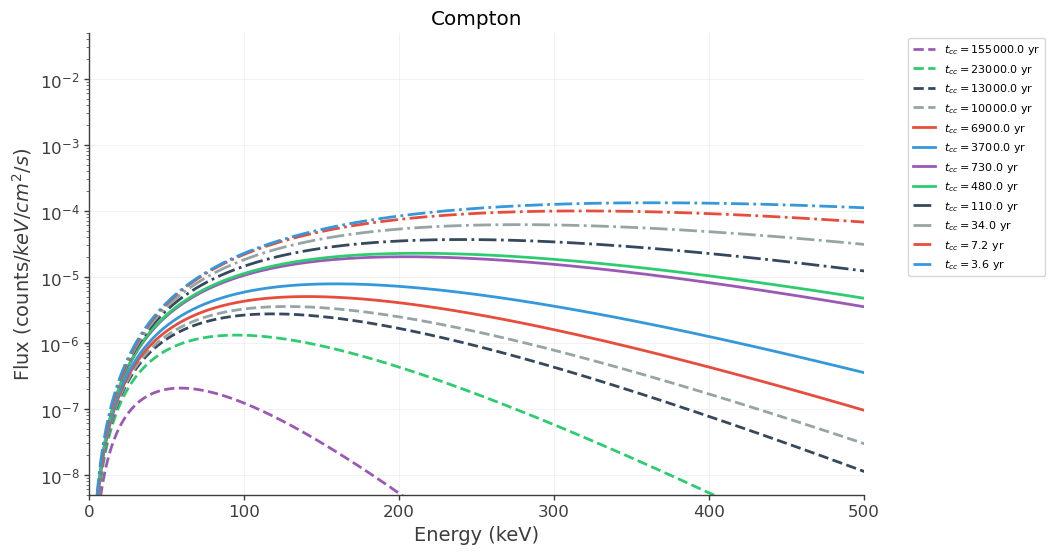

In [388]:
plt.figure(figsize=(10, 6))  # Create a larger figure

for i in range(12):
    plt.plot(E, model.get_compton_flux(E, 
                                         g_agamma=1.5, 
                                         C_C=C_C[i], 
                                         E0_C=E0_C[i], 
                                         beta_C=beta_C[i]), 
             linestyle = line_styles[i],
             label=f'$t_{{cc}} = {t_cc[i]}$ yr')

plt.xlabel('Energy (keV)')
plt.ylabel('Flux $(\mathrm{counts} / keV / cm^2 / s)$')
plt.title('Compton')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')
plt.xlim(0,500)
plt.ylim(5e-9,5e-2)
plt.show()

In [389]:
model.g_agamma = 0.5

In [390]:
g_ae = np.array([0.25, 0.5, 0.75, 1.00, 1.5, 2.0, 2.5, 3.0])

In [349]:
t_cc[4]

6900.0

# total ALP photon flux measured at Earth for g_agamma=0.5e-11 and different g_ae. same as fig. 4(a) Xiao et. al. 2022

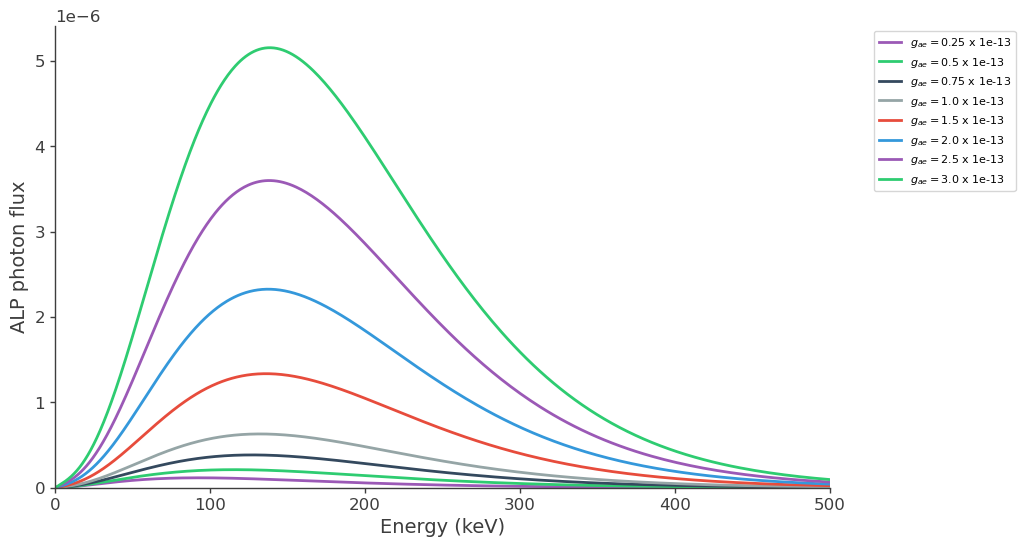

In [392]:
plt.figure(figsize=(10, 6))  # Create a larger figure

for i in range(8):
    plt.plot(E, model.evaluate(E, 
                                 g_agamma=0.5, g_ae=g_ae[i], C_B=C_B[4], E0_B=E0_B[4], beta_B=beta_B[4],
                                 C_P=C_P[4], E0_P=E0_P[4], beta_P=beta_P[4],
                                 C_C=C_C[4], 
                                 E0_C=E0_C[4], 
                                 beta_C=beta_C[4]), 
             label=f'$g_{{ae}} = {g_ae[i]}$ x 1e-13')
plt.xlabel('Energy (keV)')
plt.ylabel('ALP photon flux')
plt.xlim(0,500)
plt.ylim(0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# total ALP photon flux measured at Earth for g_agamma=1e-11 and different g_ae. same as fig. 4(b) Xiao et. al. 2022

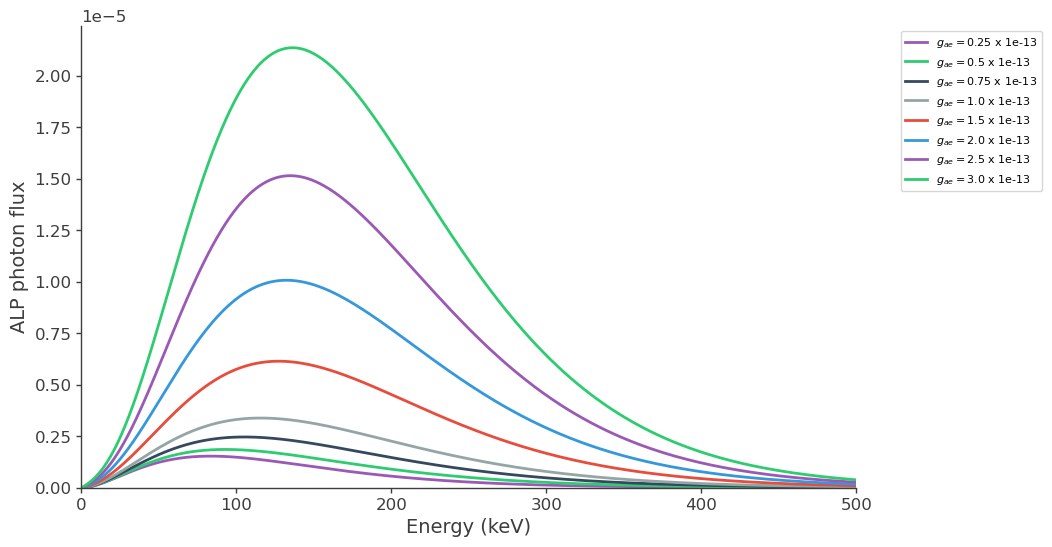

In [393]:
plt.figure(figsize=(10, 6))  # Create a larger figure

for i in range(8):
    plt.plot(E,model.evaluate(E, 
                                 g_agamma=1.0, g_ae=g_ae[i], C_B=C_B[4], E0_B=E0_B[4], beta_B=beta_B[4],
                                 C_P=C_P[4], E0_P=E0_P[4], beta_P=beta_P[4],
                                 C_C=C_C[4], 
                                 E0_C=E0_C[4], 
                                 beta_C=beta_C[4]), 
             label=f'$g_{{ae}} = {g_ae[i]}$ x 1e-13')
plt.xlabel('Energy (keV)')
plt.ylabel('ALP photon flux')
plt.xlim(0,500)
plt.ylim(0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# trying to fit our spectrum from SPI

In [354]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as c

from tqdm.autonotebook import tqdm as tqdm
import corner

from threeML import *

In [355]:
import warnings
warnings.simplefilter("ignore")

In [394]:
spec_path = 'fit_Betelgeuse_SE_it01_complete_corrected_bg_energy_lin_05_2keV_per_pointing_source_per_rev/'

In [395]:
fgBet = OGIPLike(name='fgBet',
                 observation=spec_path+'spectra_Betelgeuse_updated.fits',
                 response=spec_path+'spectral_response.rmf.fits')

09:15:01 WARNING   unable to find SPECTRUM extension: not OGIP PHA!                                      ]8;id=99860;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/pha.py\pha.py]8;;\:]8;id=232491;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/pha.py#642\642]8;;\

         WARNING   File has no SPECTRUM extension, but found a spectrum in extension SPI.-PHA1-SPE       ]8;id=838210;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/pha.py\pha.py]8;;\:]8;id=221526;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/pha.py#652\652]8;;\

         WARNING   Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.                  ]8;id=783386;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=52094;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#274\274]8;;\

         WARNING   FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.    ]8;id=255093;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=365088;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#423\423]8;;\

         WARNING   The response is in an extension called MATRIX, which usually means you also need ]8;id=663347;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py\response.py]8;;\:]8;id=381507;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py#459\459]8;;\
                  an ancillary file (ARF) which you didn't provide. You should refer to the                        
                  documentation  of the instrument and make sure you don't need an ARF.                            

         INFO      Auto-probed noise models:                                                    ]8;id=82314;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=664816;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: gaussian                                                      ]8;id=144476;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=717305;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=838124;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=981338;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

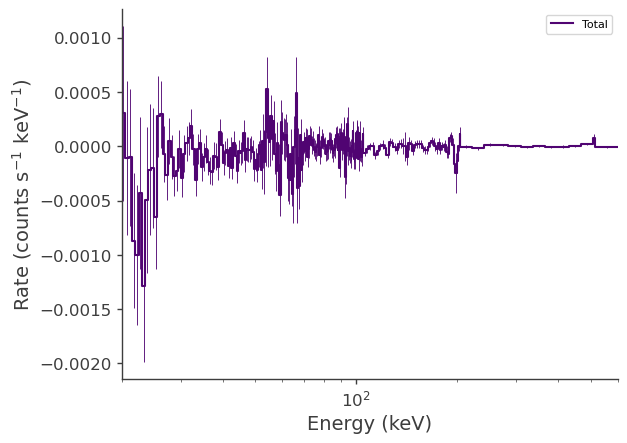

In [396]:
fgBet.view_count_spectrum()
plt.xscale('log')
plt.yscale('linear')

In [397]:
dee = fgBet.energy_boundaries[1]-fgBet.energy_boundaries[0]
ee = 0.5*(fgBet.energy_boundaries[1]+fgBet.energy_boundaries[0])
n_ee = len(ee)

In [398]:
fgBet.set_active_measurements('c0-c233')

09:15:04 INFO      Range c0-c233 translates to channels 0-233                                  ]8;id=403862;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=972508;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

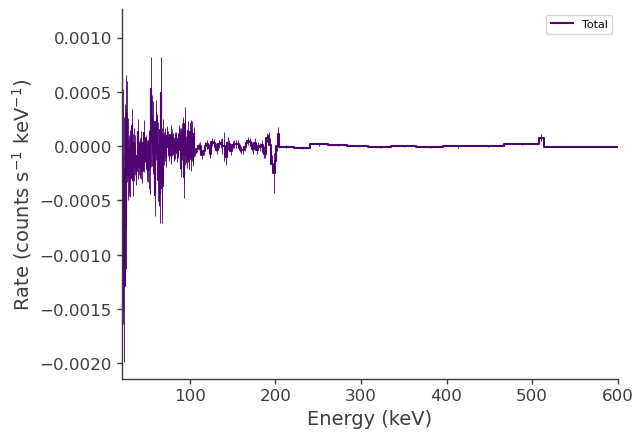

In [399]:
fgBet.view_count_spectrum()
plt.xscale('linear')
plt.yscale('linear')

In [412]:
fgBet_spectrum = ALPProductionSpectrum(g_agamma=1.0, g_ae=g_ae[-1], C_B=C_B[4], E0_B=E0_B[4], beta_B=beta_B[4],
                                 C_P=C_P[4], E0_P=E0_P[4], beta_P=beta_P[4],
                                 C_C=C_C[4], 
                                 E0_C=E0_C[4], 
                                 beta_C=beta_C[4])


In [414]:
fgBet_spectrum.ma.free = True

In [415]:
fgBet_source = PointSource("Betelgeuse", l=199.79, b=-8.96, spectral_shape=fgBet_spectrum)

fgBet_model = Model(fgBet_source)

fgBet_data = DataList(fgBet)

fgBet_model.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                      value min_value max_value   unit
Betelgeuse...g_agamma   1.0       0.0     100.0  GeV-1
Betelgeuse...g_ae       3.0       0.0     100.0       
Betelgeuse...ma         1.0       0.0     100.0     eV

Fixed parameters (14):
---------------------

                        value min_value max_value unit
Betelgeuse.position.l  199.79       0.0     360.0  deg
Betelgeuse.position.b   -8.96     -90.0      90.0  deg
Betelgeuse...C_B        0.136       0.0     100.0     
Betelgeuse...E0_B       85.15       1.0    1000.0  keV
Betelgeuse...beta_B      1.06       0.0      10.0     
Betelgeuse...C_C        31.81       0.0    1000.0     
Betelgeuse...E0_C       186.4       1.0    1000.0  keV
Betelgeuse...beta_C      3.09       0.0      10.0     
Betelgeuse...C_P          6.5       0.0     100.0     
Betelgeuse...E0_P       120.0       1.0    1000.0  keV
Betelgeuse...beta_P       2.0       0.0      10.0     
Betelgeuse...BT           1.4       0.1      10.0   uG
Betelgeuse...distance   200.0       1.0    1000.0   pc
Betelgeuse...ne         0.013     0.001       1.0     

Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [416]:
fgBet_jl = JointLikelihood(fgBet_model, fgBet_data)

best_fit_parameters_fgBet, likelihood_values_fgBet = fgBet_jl.fit()

12:42:40 INFO      set the minimizer to minuit                                             ]8;id=494186;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=569542;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         WARNING   93.47999999999999 percent of samples have been thrown away because they ]8;id=654762;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=839277;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/analysis_results.py#1737\1737]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
Betelgeuse...g_agamma,1 +/- 9,1 / GeV
Betelgeuse...g_ae,(0.1 +/- 1.6) x 10^2,
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma,(4.19 +/- 0.28) x 10,eV


Correlation matrix:

1.00,-1.00,0.01
-1.00,1.00,-0.00
0.01,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
fgBet,118.082486
total,118.082486


Values of statistical measures:

,statistical measures
AIC,242.269776
BIC,252.518088


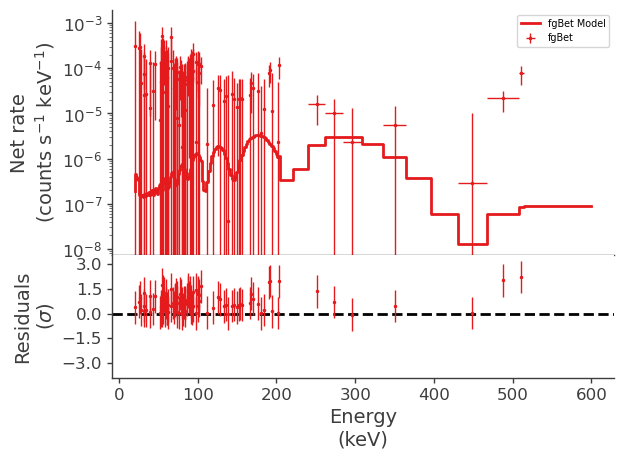

In [417]:
fgBet_jl.restore_best_fit()
wa = display_spectrum_model_counts(fgBet_jl,step=True)
wa.axes[0].set_xscale('linear')
wa.axes[0].set_yscale('log')